# Data and Package Import

## W207 House Price Prediction - Baseline Submission
### Group - Clayton Leach, Mark H, Rohini Kashibatla

In [631]:
from datetime import date
import warnings

import numpy as np
import pandas as pd
import scipy
from sklearn import preprocessing
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import scipy.stats as norm
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import xgboost

warnings.filterwarnings('ignore')

# Make it easy to see our different features within Jupyter
pd.set_option('display.max_columns', 500)

# Import our test and training datasets from local source
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

# Set our labels equal to Sale Price and remove this column from training dataset
train_labels = train_df['SalePrice']


## Summary

Based on the correlation matrix with top 10 features, we choose 6 features as explanatory variables in linear regression. This baseline model with K-folder validation gives us a sense of the goodness-of-fit on training data and model prediction error on test data.

# EDA

# Target

What does the distribution of our target variable SalePrice look like before and after Log transform

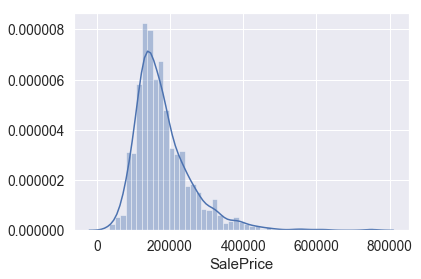

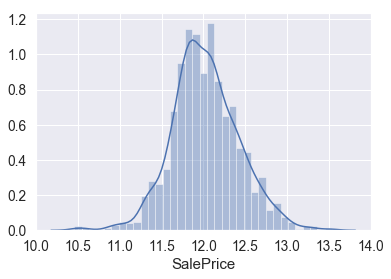

In [632]:
sns.distplot(train_df['SalePrice'])
fig = plt.figure()
sns.distplot(np.log(train_df['SalePrice']))

# Visualizing Some Categorical Variables

Understanding how categorical variable affect the distribution of SalePrice

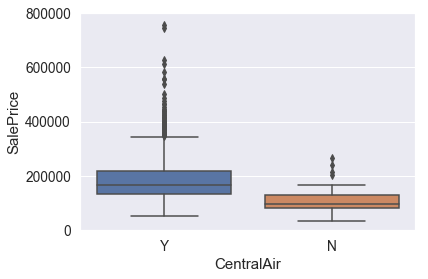

In [633]:
# CentralAir
var = 'CentralAir'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

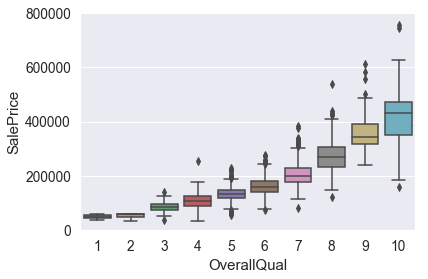

In [634]:
# OverallQual
var = 'OverallQual'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

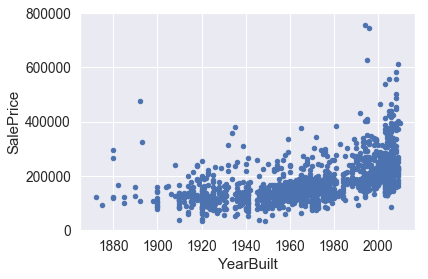

In [635]:
# YearBuilt  scatter
var = 'YearBuilt'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y="SalePrice", ylim=(0, 800000))

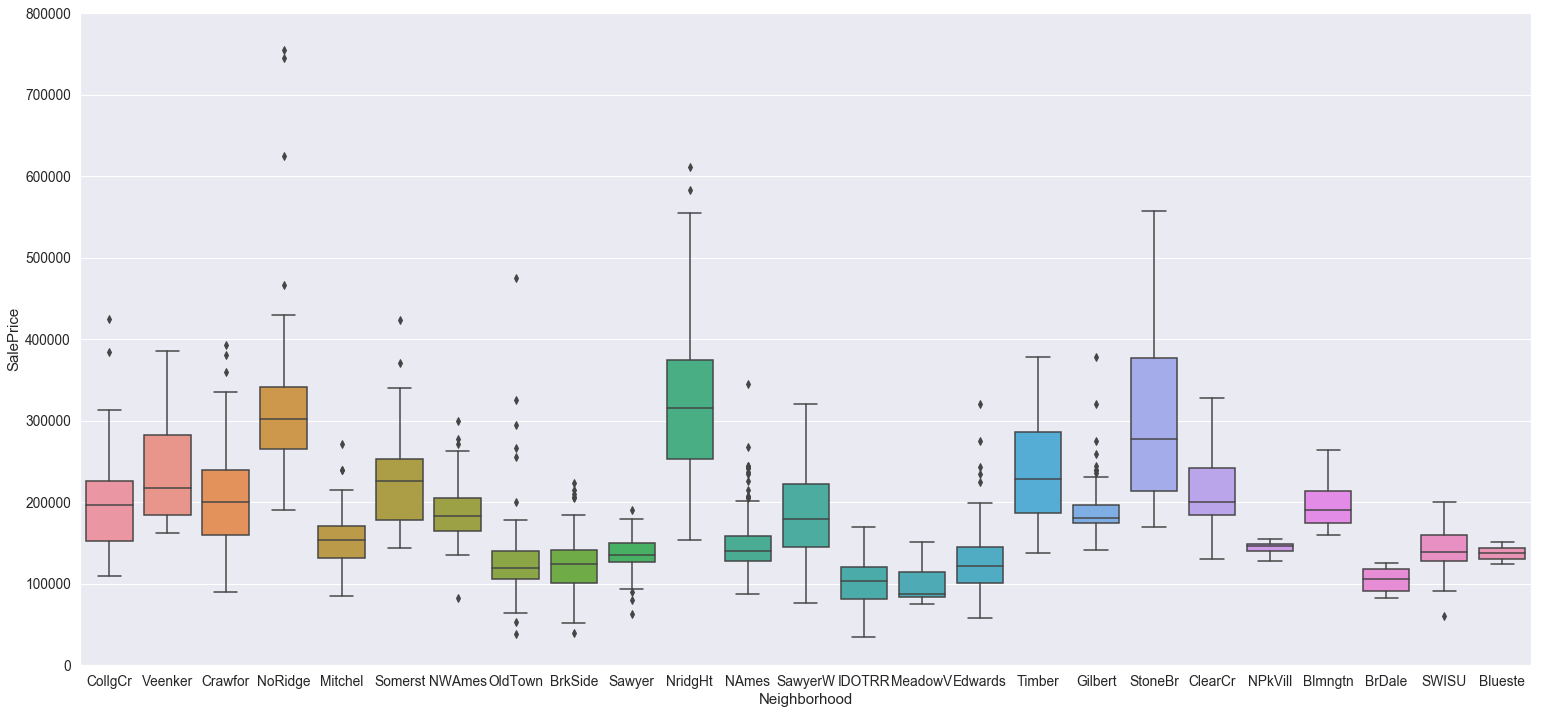

In [636]:
# Neighborhood
var = 'Neighborhood'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
f, ax = plt.subplots(figsize=(26, 12))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

# Numerical Varibales  

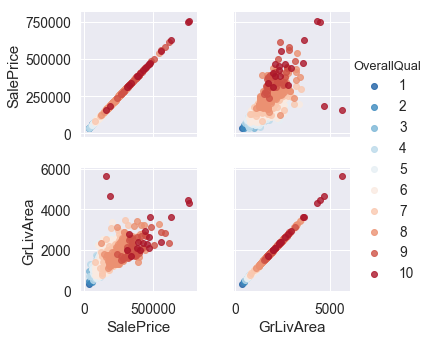

In [637]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'GrLivArea'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

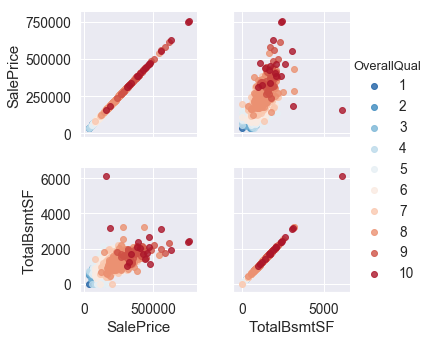

In [638]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'TotalBsmtSF'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

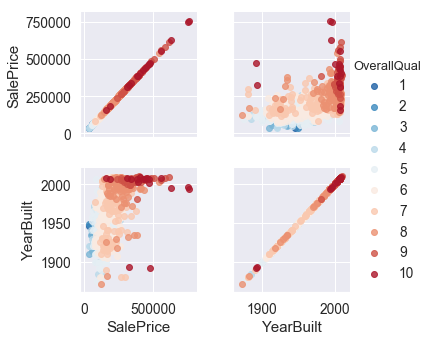

In [639]:
g = sns.PairGrid(train_df, vars=['SalePrice', 'YearBuilt'],
                 hue='OverallQual', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

# PreProcessing

Data cleaning, feature extraction, and scaling

In [640]:
def convert_categorical_to_dummy(df, columns = [], drop_first = False, dummy_na = True):
    """
    Convert all categorical variables to k dummy variables.  Include NaNs as a column as this indicates
    the absense of a feature and might be useful in non-linear models
    """
    if len(columns) > 0:
        new_df = pd.get_dummies(df, drop_first = drop_first, columns = columns, dummy_na=dummy_na)
    else:
        new_df = pd.get_dummies(df, drop_first = drop_frist, dummy_na=dummy_na)
        
    return new_df
        

In [641]:
def recession_indicator(row):
    """Take in sale date and return whether it was during recession
    as determined by official statistics; only include the recession
    which occured during years in question, but can expand as necessary
    https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States"""
    
    period = date(row['YrSold'],row['MoSold'],1)
    if (period >= date(2007,12,1)) & (period <= date(2009,6,1)) :
        return 'recession'
    else:
        return ''

In [642]:
# Convert year based features to age; Most recent year is 2010, so we will treat that as year 0
def convert_year_to_age(row, columns):
    """Helper function to convert year features into age from sale date"""
    for col in columns:
        row[col] = row['YrSold']-row[col]
    return row

In [643]:
def random_data_cleaning(df):

   # VnrType has None to indicate None but also NaNs.  Convert None to NaN to treat them identically
    df['MasVnrType'] = df['MasVnrType'].apply(lambda x: np.nan if x == 'None' else x)

   # Vnr Area is NaN when there is no Vnr.  Therefore, this is identical to setting to 0
    df['MasVnrArea'] = df['MasVnrArea'].apply(lambda x: 0 if np.isnan(x) else x )

   # Assume NaN indicates there is no street connected to property, therefore 0 feet
    df['LotFrontage'] = df['LotFrontage'].apply(lambda x: 0 if np.isnan(x) else x)

   # Convert Garage Year Built to categorical (Picked 1990 arbitrarily)
    df['GarageYrBlt'] = df['GarageYrBlt'].apply(lambda x: 'old' if x < 1990 else ('new' if
                                              x >1990 else 'no garage'))
   # Assume NaN indicates that house does not have object feature refers to.  Since it is a numeric
   # feature we set it to 0. (E.g. not having a basement is identical to having a basement of 0 sqft)
    df['MasVnrArea'] = df['MasVnrArea'].apply(lambda x: 0 if np.isnan(x) else x )
    df['LotFrontage'] = df['LotFrontage'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtFinSF1'] = df['BsmtFinSF1'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtFinSF2'] = df['BsmtFinSF2'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtUnfSF'] = df['BsmtUnfSF'].apply(lambda x: 0 if np.isnan(x) else x)
    df['TotalBsmtSF'] = df['TotalBsmtSF'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtFullBath'] = df['BsmtFullBath'].apply(lambda x: 0 if np.isnan(x) else x)
    df['BsmtHalfBath'] = df['BsmtHalfBath'].apply(lambda x: 0 if np.isnan(x) else x)
    df['GarageCars'] = df['GarageCars'].apply(lambda x: 0 if np.isnan(x) else x)
    df['GarageArea'] = df['GarageArea'].apply(lambda x: 0 if np.isnan(x) else x)

    return df

In [644]:
train_df['recession'] = train_df.apply(lambda x: recession_indicator(x), axis = 1)
test_df['recession'] = test_df.apply(lambda x: recession_indicator(x), axis = 1)

In [645]:
train_df = random_data_cleaning(train_df)
test_df = random_data_cleaning(test_df)

In [646]:
"""Note: Garage Year Built can't be converted to age as not every property has a garage"""

year_cols = ['YearBuilt','YearRemodAdd',]
new_train = train_df.apply(convert_year_to_age, args=(year_cols,), axis=1)
new_test = test_df.apply(convert_year_to_age, args=(year_cols,), axis=1)


In [647]:
# List of columns which we believe it makes sense to convert to boolean. 


categorical_columns = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
                       'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle',
                       'RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
                       'BsmtQual','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional',
                       'GarageType','PavedDrive','PoolQC','Fence','MiscFeature','MoSold','SaleType',
                       'SaleCondition','recession','YrSold']

"""Need to separate these out so we can specify not to include a column for NaNs.  We do this because we 
will have already created this column.  For Basement, if there is no basement we will create the no basement
column by splitting "BsmtQual", and for Garage we will do so by splitting "GarageType".  This would naturally
be resolved in PCA as they would be perfectly correlated, but we opt to resolve this prior to PCA."""

categorical_columns_no_nan = ['BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageFinish',
                       'GarageQual','GarageCond','GarageYrBlt','FireplaceQu',]

new_train = convert_categorical_to_dummy(new_train,categorical_columns)
new_test = convert_categorical_to_dummy(new_test,categorical_columns)

new_train = convert_categorical_to_dummy(new_train,categorical_columns_no_nan, dummy_na=False)
new_test = convert_categorical_to_dummy(new_test,categorical_columns_no_nan, dummy_na=False)

#Use to cluster neighborhoods later
neighborhoods = [col for col in new_train.columns if "Neighborhood" in col]+['GrLivArea', 'SalePrice']
neighborhood_df = new_train[neighborhoods]

styles = [col for col in new_train.columns if "HouseStyle" in col]+['GrLivArea', 'SalePrice']
styles_df = new_train[styles]


# Remove SalePrice from training set as it is our target variable
new_train = new_train.drop(['SalePrice'], axis=1)

In [648]:
# Get missing columns in the training test
missing_cols = set( new_train.columns ) - set( new_test.columns )

# Add a missing column in test set with default value equal to 0
for col in missing_cols:
    new_test[col] = 0
    
# Ensure matching order and columns between train and test sets
new_test = new_test[new_train.columns]

In [649]:
# Check to make sure that our missing columns are only derived from the test data lacking specific instances
# of a categorical variable.  
for col in missing_cols:
    if (col.split("_")[0] not in categorical_columns) &(col.split("_")[0] not in categorical_columns_no_nan):
        print("Error, %s was not derived from a missing category" %col)

In [650]:
# Use SKLearn scaling 
def min_max_scaling(df, columns):
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_df = min_max_scaler.fit_transform(df)
    scaled_df = pd.DataFrame(scaled_df,columns = columns)
    return scaled_df, min_max_scaler

# Opt for min-max scaling as opposed to mean normalization as we have so many boolean variables.  Min-Max
# preserve the 0/1 nature of these features.  We may revisit using alternative scaling methods in future
# iterations of preprocessing

scaled_train, min_max_scaler_train = min_max_scaling(new_train, new_train.columns)
#scaled_train['Id'] = scaled_train.index + 1

scaled_test = pd.DataFrame(min_max_scaler_train.transform(new_test),columns=new_test.columns)
#scaled_test['Id'] = scaled_test.index + 1

In [651]:
# Confirm none of our columns contain NaN values
scaled_train.columns[scaled_train.isna().any()].tolist()

[]

# Baseline

In [652]:
# metric for evaluation
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    sum_sq = sum(diff**2)    
    n = len(y_pred)   
    
    return np.sqrt(sum_sq/n)


## Correlation Matrix
Top 10 most correlated features to SalePrice

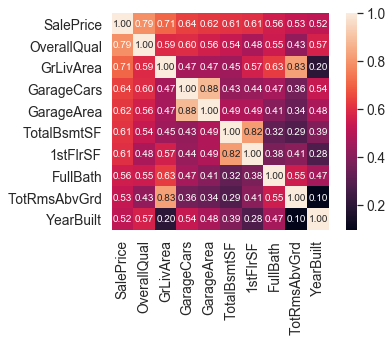

In [653]:
corrmat = train_df.corr()
k = 10
cols = corrmat.nlargest(k,'SalePrice')['SalePrice'].index
cm = np.corrcoef(train_df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [654]:
print(cols)
#g = sns.pairplot(scaled_train[cols])

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


In [655]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
x = scaled_train[cols].values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))

In [656]:
# Do K-folds to create train/test splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

In [657]:
for train, test in kf.split(x):
    # Use index to create train and test data and labels
    train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]
    
    # Create instance of LinearRegression object from SKLearn
    model = linear_model.LinearRegression()
    model.fit(train_data,train_label)
    print("The R^2 for this run is: %s" %model.score(train_data,train_label))
    
   
    y_pred = model.predict(test_data)
    print("The Root Mean Squared Error for this run is: %s" %rmse(test_label,y_pred))

The R^2 for this run is: 0.8017927803942895
The Root Mean Squared Error for this run is: [0.16411907]
The R^2 for this run is: 0.8342677558662451
The Root Mean Squared Error for this run is: [0.22263131]
The R^2 for this run is: 0.8096564009441117
The Root Mean Squared Error for this run is: [0.16500317]
The R^2 for this run is: 0.814807117401844
The Root Mean Squared Error for this run is: [0.17247055]
The R^2 for this run is: 0.804872177212174
The Root Mean Squared Error for this run is: [0.15409332]


In [658]:
cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
x = scaled_train[cols].values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))
model = linear_model.LinearRegression()
model.fit(x,y_log)
x_test = scaled_test[cols].values
predictions = model.predict(x_test)
predictions = np.exp(predictions)


In [659]:
test_df['Id']
submission = pd.DataFrame({'Id':test_df['Id']})
submission['SalePrice'] = np.round(predictions,2)
submission.head()
filename = 'submission.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission.csv


Kaggle Submission
Made with userid - testrk
3195 new testrk testrk 0.16667

Your Best Entry 
Your submission scored 0.16667, which is not an improvement of your best score. Keep trying!





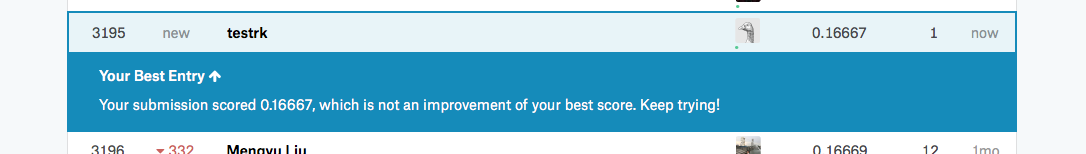

In [660]:
from IPython.display import Image
Image(filename='kaggle_submit.png') 

## Support Vector Regression

In [661]:
# SVR 
def model_svr():
    
    from sklearn.svm import SVR
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    svr_lin = SVR(kernel='linear', C=1e3)
    svr_poly = SVR(kernel='poly', C=1e3, degree=3)
    y_rbf = svr_rbf.fit(x, y).predict(x_test)
    y_lin = svr_lin.fit(x, y).predict(x_test)
    y_poly = svr_poly.fit(x, y).predict(x_test)

    # Do K-folds to create train/test splits
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    for train, test in kf.split(x):
        # Use index to create train and test data and labels
        train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]

        svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
        svr_rbf.fit(train_data,train_label)
        print("svr_rbf The R^2 for this run is: %s" %svr_rbf.score(train_data,train_label))

        #svr_lin = SVR(kernel='linear', C=1e3)
        svr_lin = SVR(kernel='linear', C=1000)
        svr_lin.fit(train_data,train_label)
        print("svr_lin The R^2 for this run is: %s" %svr_lin.score(train_data,train_label))

        svr_poly = SVR(kernel='poly', C=1e3, degree=3)
        svr_poly.fit(train_data,train_label)
        print("svr_poly The R^2 for this run is: %s" %svr_poly.score(train_data,train_label))


        y_pred = svr_rbf.predict(test_data)
        r = rmse(test_label,y_pred)
        #print(r)
        #print("The Root Mean Squared Error for this run is: %s" %rmse(test_label,y_pred))



    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import classification_report

    # Set the parameters by cross-validation
    parameters = [{'kernel': ['rbf'],
                   'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5],
                    'C': [1, 10, 100, 1000,1e3]},
                  {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    print("# Tuning hyper-parameters")
    print()

    model = GridSearchCV(SVR(kernel='rbf'), parameters, cv=5)
    model.fit(x, y)

    print("Best parameters set found on development set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    cols = ['OverallQual','GrLivArea', 'GarageCars','TotalBsmtSF','TotRmsAbvGrd', 'YearBuilt']
    x = scaled_train[cols].values
    y = train_labels.values
    y_log = np.log(y.reshape(-1,1))

    #svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    #svr_rbf = SVR(kernel='rbf', C=1000000.0, gamma=0.5,epsilon=0.25)
    svr_rbf = model
    svr_rbf.fit(train_data,train_label)
    svr_rbf.fit(x,y_log)
    x_test = scaled_test[cols].values
    predictions = svr_rbf.predict(x_test)

    predictions = np.exp(predictions)

    test_df['Id']
    submission = pd.DataFrame({'Id':test_df['Id']})
    submission['SalePrice'] = np.round(predictions,2)
    submission.head()
    filename = 'submission_svr.csv'
    submission.to_csv(filename,index=False)
    print('Saved file: ' + filename)




Modeling to do list:

    1) Do all of the below both pre and post PCA (Mark wants to write PCA function)

    2) Do all of the below both pre and post k-means++ clustering

Models:

    1) Neural net (Feed Forward)

    2) XGBoost (or RF) (Clay)

    3) GMM

    4) SVM (Rohini)

    5) KNN (Restrict what features we use)
    
    6) Elastic Net (Mark)



In [662]:
# PCA + GXBoost = Best | Clay & Rohini prediction
# Lasso Regression     | Mark predicts this will be the hard to beat

## XGBOOST

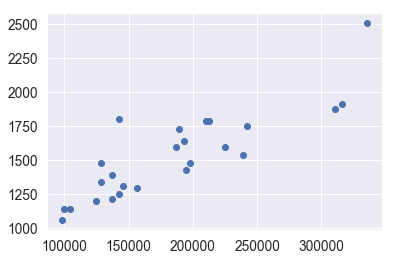

In [663]:
# See if there is a way to collapse neighborhoods
nhoods = [col for col in new_train.columns if "Neighborhood" in col]
neighborhood_agg = neighborhood_df.groupby(nhoods).agg({"SalePrice":"mean","GrLivArea":"mean" }).reset_index()
x=neighborhood_agg["SalePrice"]
y=neighborhood_agg["GrLivArea"]
plt.scatter(x,y)

From the above we can see there are two neighborhoods which don't fit the general linear trend between
sqft and price.  We will only include these two neighborhoods, as they should be the only neighborhood
variables which convey additional information

    Neighborhood_SWISU : Significantly more SQft for price relative to other neighborhoods
    Neighborhood_NoRidge : Very expensive, but significantly more SQft than pattern observed elsewhere

In [664]:
kept_nhoods = ["Neighborhood_SWISU", "Neighborhood_NoRidge"]
dropped_nhoods = [nhood for nhood in nhoods if nhood not in kept_nhoods]
df = new_train.drop(dropped_nhoods, axis = 1)
df_test = new_test.drop(dropped_nhoods, axis = 1)

In [665]:
# No reason not to combine these values into single feature
df["baths"] = df["FullBath"]+.5*df["HalfBath"]
df = df.drop(['FullBath','HalfBath'], axis = 1)

df_test["baths"] = df_test["FullBath"]+.5*df_test["HalfBath"]
df_test = df_test.drop(['FullBath','HalfBath'], axis = 1)

In [666]:
df['BasmtBaths'] = df['BsmtFullBath'] + .5*df['BsmtHalfBath']
df = df.drop(['BsmtFullBath','BsmtHalfBath'], axis = 1)

df_test['BasmtBaths'] = df_test['BsmtFullBath'] + .5*df_test['BsmtHalfBath']
df_test = df_test.drop(['BsmtFullBath','BsmtHalfBath'], axis = 1)

In [667]:
# Very rarely do these deviate significantly; GrLivArea captures total SqFt, and 1story captures number of stories
df = df.drop(['1stFlrSF',"2ndFlrSF"], axis = 1 )

df_test = df_test.drop(['1stFlrSF',"2ndFlrSF"], axis = 1 )

In [668]:
# Combine into single score
df["Qual+Cond"] = df['OverallQual'] + df['OverallCond']
df = df.drop(['OverallQual', 'OverallCond'], axis = 1)

df_test["Qual+Cond"] = df_test['OverallQual'] + df_test['OverallCond']
df_test = df_test.drop(['OverallQual', 'OverallCond'], axis = 1)

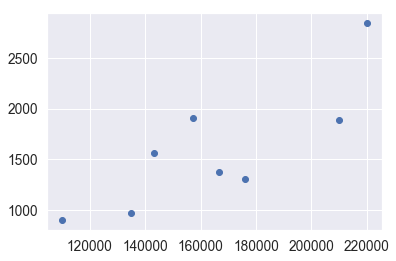

In [669]:
# See if there is a way to collapse neighborhoods
styles = [col for col in new_train.columns if "HouseStyle" in col]
style_agg = styles_df.groupby(styles).agg({"SalePrice":"mean","GrLivArea":"mean" }).reset_index()
x=style_agg["SalePrice"]
y=style_agg["GrLivArea"]
plt.scatter(x,y)

Nothing looks too out of the ordinary so I won't cut any of these variables

In [670]:
df = df.drop("Id", axis = 1)
df_test = df_test.drop("Id", axis = 1)

df = df.drop("TotalBsmtSF", axis = 1)
df_test = df_test.drop("TotalBsmtSF", axis = 1)

In [671]:
scaled_df, min_max_scaler_train = min_max_scaling(df, df.columns)
scaled_df_test = min_max_scaler_train.transform(df_test)

In [672]:
def feature_selection_xgboost(df, train_labels, iterations=10, threshold = .001):
    irrelevant_cols_total = []
    new_df = df
    
    for x in range(0,iterations):
        x = df.values
        y = train_labels.values
        y_log = np.log(y.reshape(-1,1))

        kf = KFold(n_splits=5, shuffle=True)
        
        rmse_sum = 0
        for train, test in kf.split(x):
            # Use index to create train and test data and labels
            train_data, train_label, test_data, test_label = x[train], y_log[train], x[test], y_log[test]

            # Create instance of LinearRegression object from SKLearn
            xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                                   colsample_bytree=1, max_depth=7)
            xgb.fit(train_data,train_label)


            predictions = xgb.predict(test_data)
            print("The Root Mean Squared Error for this run is: %s" %rmse(test_label.reshape(test_label.shape[0],),
                                                                          predictions))
            rmse_sum +=rmse(test_label.reshape(test_label.shape[0],),predictions)
        print("Total rmse for these runs is %s" % rmse_sum)
        irrelevant_cols = df.columns[xgb.feature_importances_< threshold]
        irrelevant_cols_total += list(irrelevant_cols)
        df = df.drop(irrelevant_cols, axis = 1)
        print(df.shape)
    return df,irrelevant_cols_total

In [690]:
subset_df, dropped_cols = feature_selection_xgboost(df,train_labels)

The Root Mean Squared Error for this run is: 0.13581776269493404
The Root Mean Squared Error for this run is: 0.12098101245960687
The Root Mean Squared Error for this run is: 0.1298252340074576
The Root Mean Squared Error for this run is: 0.1292749473154122
The Root Mean Squared Error for this run is: 0.1390409203736028
Total rmse for these runs is 0.6549398768510135
(1460, 158)
The Root Mean Squared Error for this run is: 0.11883879968924013
The Root Mean Squared Error for this run is: 0.13278290114154148
The Root Mean Squared Error for this run is: 0.15440876499289855
The Root Mean Squared Error for this run is: 0.13413151825630243
The Root Mean Squared Error for this run is: 0.11117295834285346
Total rmse for these runs is 0.6513349424228361
(1460, 120)
The Root Mean Squared Error for this run is: 0.13082676353433767
The Root Mean Squared Error for this run is: 0.11904374773737159
The Root Mean Squared Error for this run is: 0.12105503312457597
The Root Mean Squared Error for this r

In [674]:
x = subset_df.values
x_test = df_test.drop(dropped_cols,axis=1).values
y = train_labels.values
y_log = np.log(y.reshape(-1,1))

xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=.001, subsample=0.75,
                           colsample_bytree=1, max_depth=4)
xgb.fit(x,y_log)


predictions = xgb.predict(x_test)

In [675]:
predictions = np.exp(predictions)

In [676]:
test_df['Id']
submission = pd.DataFrame({'Id':test_df['Id']})
submission['SalePrice'] = np.round(predictions,2)
submission.head()
filename = 'submission_xgboost.csv'
submission.to_csv(filename,index=False)
print('Saved file: ' + filename)

Saved file: submission_xgboost.csv


1880

Your Best Entry 

You advanced 2,505 places on the leaderboard!

Your submission scored 0.13369, which is an improvement of your previous score of 0.67275. Great job!

^^ (Score of .67275 has to have been a submission error on my part, I refuse to believe my first try was that bad)